# Training

In [1]:
import sys
import os
from dotenv import load_dotenv

load_dotenv()

root_project_path = os.getenv("ROOTH_PATH")
sys.path.append(root_project_path)
print(root_project_path)

/home/jbct/Projects/thesis/db-ocsvm/


In [ ]:
import pandas as pd
from constants.dataset_paths import DATASET

train_set_path = DATASET["processed"]["CIDDS-001"]["train_full"]
train_dataset = pd.read_csv(train_set_path)
print(f"train set count: {train_dataset.shape[0]:,}")
train_dataset.head(3)

train set count: 180,000


,duration,packets,bytes,flows,tcp_urg,tcp_ack,tcp_psh,tcp_rst,tcp_syn,tcp_fin,tos,attack_id,proto_ICMP,proto_IGMP,proto_TCP,proto_UDP,attack_binary,attack_categorical
0,-0.053152,-0.375,-0.310330,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,benign
1,-0.402967,0.000,0.355686,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,benign
2,0.097651,-0.500,-0.294488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,benign


Get only normal class from the train set

In [3]:
train_set = train_dataset[train_dataset["attack_binary"] == 1]

verify that only normal 'attack' types exist

In [4]:
unique_attacks = train_set["attack_binary"].unique()
print(f"train set count: {train_set.shape[0]:,}")
print(unique_attacks)

train set count: 180,000
[1]


In [ ]:
from sklearn.svm import OneClassSVM

ocsvm = OneClassSVM(kernel="rbf", gamma="auto", nu=0.2, verbose=True)

# Train the model on the normal data sample
ocsvm.fit(
    train_set.drop(columns=["attack_binary", "attack_categorical"]).sample(frac=0.1)
)

[LibSVM]..
*.*
optimization finished, #iter = 3015
obj = 681452.645183, rho = 652.849660
nSV = 3605, nBSV = 3596


OneClassSVM(gamma='auto', nu=0.2, verbose=True)

# Testing

Preparing test set

In [ ]:
test_set_path = DATASET["processed"]["CIDDS-001"]["test"]

test_set = pd.read_csv(test_set_path)
print(f"test set count: {test_set.shape[0]:,}")

test set count: 20,000


In [7]:
test_set.head(3)

,duration,packets,bytes,flows,tcp_urg,tcp_ack,tcp_psh,tcp_rst,tcp_syn,tcp_fin,tos,attack_id,proto_ICMP,proto_IGMP,proto_TCP,proto_UDP,attack_binary,attack_categorical
0,-0.309023,-0.375,-0.217882,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,benign
1,1.660074,-0.625,-0.322483,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,benign
2,1.728059,1.250,0.225260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,benign


In [9]:
X_test = test_set.drop(columns=["attack_binary", "attack_categorical"])

y_test = test_set["attack_binary"]
print(y_test.unique())

[ 1 -1]


Perform prediction

In [10]:
y_pred = ocsvm.predict(X_test)

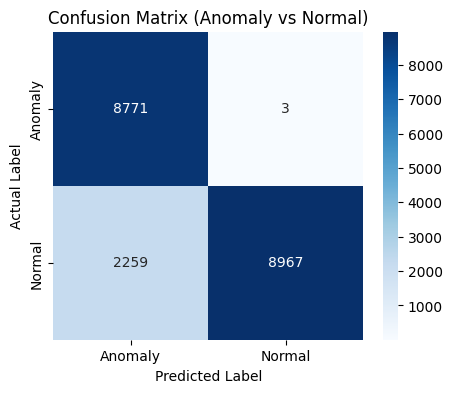

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=[-1, 1])


def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(title)
    plt.show()


plot_confusion_matrix(cm, ["Anomaly", "Normal"], "Confusion Matrix (Anomaly vs Normal)")

In [ ]:
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Anomaly", "Normal"]))

precision = precision_score(y_test, y_pred, pos_label=-1)
recall = recall_score(y_test, y_pred, pos_label=-1)
f1 = f1_score(y_test, y_pred, pos_label=-1)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Classification Report:
              precision    recall  f1-score   support

     Anomaly       0.80      1.00      0.89      8774
      Normal       1.00      0.80      0.89     11226

    accuracy                           0.89     20000
   macro avg       0.90      0.90      0.89     20000
weighted avg       0.91      0.89      0.89     20000

Precision: 0.7951949229374433
Recall: 0.9996580806929565
F1 Score: 0.8857806503736619
Accuracy: 0.8869
